In [1]:
import numpy as np
import cv2
import os
from math import ceil
import time
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import pandas as pd
import random
%matplotlib inline

Using TensorFlow backend.


In [2]:
labels = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

#建立相應資料夾
#建立處理過後的 training 資料夾
train_path = "ml100-03-final/processed image data/train/"
for l in labels:
    try:
        os.makedirs(os.path.join(train_path, l))
    except OSError:
        pass
    
#建立處理過後的 training for validation 資料夾
val_path = "ml100-03-final/processed image data/val/"
for l in labels:
    try:
        os.makedirs(os.path.join(val_path, l))
    except OSError:
        pass
    
#建立處理過後的 testing 資料夾
test_path = "ml100-03-final/processed image data/test"
try:
    os.makedirs(test_path)
except OSError:
    pass

In [3]:
# 將檔案預處理，並且分別存在新的資料夾中
def preprocessing_from_folder(path_from, path_train, path_val, rt):
    nf = len(os.listdir(path_from))
    for i, filename in enumerate(os.listdir(path_from)):
        im = cv2.imread(os.path.join(path_from, filename))
        h = im.shape[0]
        w = im.shape[1]
        #旋轉使其寬>高
        if(h > w):   
            im = np.rot90(im)
        h = im.shape[0]
        w = im.shape[1]
        #等比例調整使其高度是240
        r = 240/h
        im = cv2.resize(im, (ceil(w*r), 240), interpolation=cv2.INTER_CUBIC)
        h = im.shape[0]
        w = im.shape[1]
        #砍掉左右不需要的部分，只留下240*240 中間的正方形
        x_l = ceil((w-240)/2)
        crop_img = im[0:240, x_l:x_l+240]
        #rt 為要拿來分割training data 的比例
        if ((i/(nf-1))<=rt):
            cv2.imwrite(os.path.join(path_train, filename), crop_img)
        else:
            cv2.imwrite(os.path.join(path_val, filename), crop_img)

In [4]:
from_path = "ml100-03-final/image_data/train/"
rt = 0.95 #將有label 的 data 分成 train 與 validation
#圖片格式整理，並且另存整理後的圖片
for l in labels:
    preprocessing_from_folder(os.path.join(from_path, l), os.path.join(train_path, l), os.path.join(val_path, l), rt)

from_test_path = "ml100-03-final/image_data/test/"
preprocessing_from_folder(from_test_path, test_path, [], 1)

圖片格式整理前
type= <class 'numpy.ndarray'>  H:240 W:320


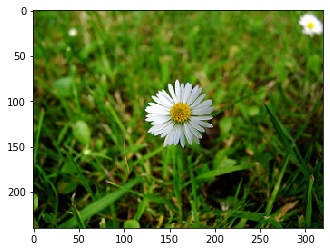

圖片格式整理後
type= <class 'numpy.ndarray'>  H:240 W:240


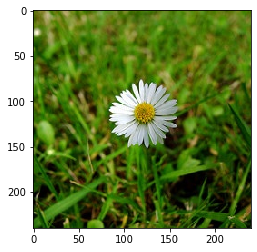

In [5]:
#tf_name = "0a3e7507742e246b3a2e630debbbaf99.jpg"
tf_name = "44be62b2f3895951c118719bdbf2ab26.jpg"

print('圖片格式整理前')
img = cv2.imread(os.path.join("ml100-03-final/image_data/train/daisy/", tf_name))
print('type=', type(img), ' H:%d W:%d'%((img.shape)[0], (img.shape)[1]))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print('圖片格式整理後')
img = cv2.imread(os.path.join("ml100-03-final/processed image data/train/daisy/", tf_name))
print('type=', type(img), ' H:%d W:%d'%((img.shape)[0], (img.shape)[1]))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
#建立 (x_train, y_train) 與 (x_val, y_val)
x_train = []
y_train = []
x_val = []
y_val = []


#讀取 training data
for i, l in enumerate(labels):
    l_path = os.path.join(train_path, l)
    for filename in os.listdir(l_path):
        im = cv2.imread(os.path.join(l_path, filename))
        x_train.append(im)
        #label
        y_tmp = np.zeros((5,), dtype=int)
        y_tmp[i] = 1
        y_train.append(y_tmp)
        
#讀取 validation data
for i, l in enumerate(labels):
    l_path = os.path.join(val_path, l)
    for filename in os.listdir(l_path):
        im = cv2.imread(os.path.join(l_path, filename))
        x_val.append(im)
        #label
        y_tmp = np.zeros((5,), dtype=int)
        y_tmp[i] = 1
        y_val.append(y_tmp)


x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [7]:
print("x_train shape = ", x_train.shape)
print("y_train shape = ", y_train.shape)
print("x_val shape = ", x_val.shape)
print("y_val shape = ", y_val.shape)

x_train shape =  (2680, 240, 240, 3)
y_train shape =  (2680, 5)
x_val shape =  (143, 240, 240, 3)
y_val shape =  (143, 5)


In [8]:
#建立 test data， 用 filename 映射到 image 的 dictionary 來儲存
test_dict = {}
for filename in os.listdir(test_path):
    im = cv2.imread(os.path.join(test_path, filename))
    f_name = filename[:-4] #去掉後面的.jpg
    test_dict[f_name] = im    

直接讀取檔案 0bfd70207c02f6fc77f4835468024c2a


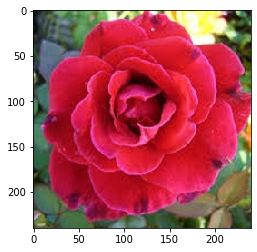

透過test_dict讀取檔案 0bfd70207c02f6fc77f4835468024c2a


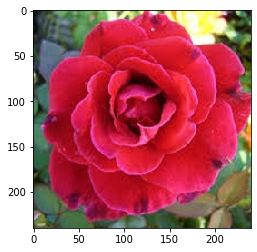

In [9]:
#測試 test data 的 dictionary 是否成功建立

# tf_name = "0a17a40da339434863c4ae1382d8ab51"
tf_name = "0bfd70207c02f6fc77f4835468024c2a"
im = cv2.imread(os.path.join(test_path, tf_name+".jpg"))
print("直接讀取檔案", tf_name)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()
print("透過test_dict讀取檔案", tf_name)
im = test_dict[tf_name]
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()


### 將 train validation 與 test normalized (可以選擇不要 normalized)

In [ ]:
#normalize
x_train = x_train.astype('float32')
x_train /= 255
x_val = x_val.astype('float32')
x_val /= 255

for k in test_dict.keys():
    im = test_dict[k]
    im = im.astype('float32')
    im /= 255
    test_dict[k] = im

In [ ]:
print(np.amax(x_train[0])) #np.amax 取矩陣中最大的值
print(np.amax(x_val[0]))
print(np.amax(test_dict[tf_name]))

In [10]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, img_label=0, ncols=8, size=1, path=False):
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(1.5*ncols*size, 1.5*nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in enumerate(axes):
            nth=r
            if nth < nimg:
                ax.imshow(cv2.cvtColor(img[nth], cv2.COLOR_BGR2RGB), cmap='rainbow', vmin=0, vmax=1)
                if not isinstance(img_label, int):
                    ax.set_title(labels[img_label[nth]])
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in enumerate(axes):
            nth=c
            if nth < nimg:
                ax.imshow(cv2.cvtColor(img[nth], cv2.COLOR_BGR2RGB), cmap='rainbow', vmin=0, vmax=1)
                if not isinstance(img_label, int):
                    ax.set_title(labels[img_label[nth]])
            ax.set_axis_off()
    else:
        for r, row in enumerate(axes):
            for c, ax in enumerate(row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(cv2.cvtColor(img[nth], cv2.COLOR_BGR2RGB), cmap='rainbow', vmin=0, vmax=1)
                    if not isinstance(img_label, int):
                        ax.set_title(labels[img_label[nth]])
                ax.set_axis_off()
    plt.show()

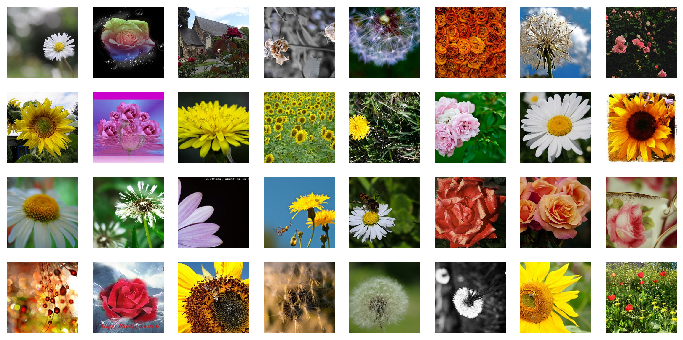

In [12]:
# 取隨機 show_num 張圖片做視覺化
show_num = 32  #秀 show_num 組預測組看看效果

ind_2000 = list(range(len(test_dict)))
random.shuffle(ind_2000)
rand_ind = ind_2000[:show_num] #隨機選取 show_num 個


img_combine(x_train[rand_ind, :])

#### Import 一堆東西

In [13]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
from keras.models import Model
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator

### CNN model Version 1

In [ ]:
# 建立 CNN model

# RTX 2080 才跑得動， Model 參數太多!
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(SeparableConv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(SeparableConv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.40))
model.add(Dense(5))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['categorical_accuracy'])

In [ ]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [ ]:
# training
batch_size = 20 # batch 的大小，如果出現 OOM error，請降低這個值

epochs = 50 # 訓練的 epochs 數量

time_array = time.localtime() # localtime
time_str = time.strftime('%m-%dT%H%M%S', time_array)
save_model_name = "model_"+time_str+".h5"

#存val_loss 最低的model的 call back func
model_ckpt = ModelCheckpoint(filepath="./"+save_model_name, 
                             monitor="val_loss",
                             save_weights_only = False,
                             save_best_only=True)


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    callbacks=[model_ckpt],
                    validation_data=(x_val, y_val))

In [ ]:
score = model.evaluate(x_val, y_val, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### ResNet 50 Model

In [ ]:
# 影像大小
IMAGE_SIZE = (240, 240)

# 影像類別數
NUM_CLASSES = 5

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 8

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 20

In [ ]:
# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# 資料路徑
train_batches = train_datagen.flow_from_directory(train_path,
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(val_path,
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)
# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

In [ ]:
# 模型輸出儲存的檔案
time_array = time.localtime() # localtime
time_str = time.strftime('%m-%dT%H%M%S', time_array)
save_model_name = 'model-resnet50-'+time_str+'.h5'

# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))

x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)

for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# 輸出整個網路結構
print(net_final.summary())

In [ ]:
#存val_loss 最低的model的 call back func
model_ckpt = ModelCheckpoint(filepath=save_model_name, 
                             monitor="val_loss",
                             save_weights_only = False,
                             save_best_only=True)
# 訓練模型
# history = net_final.fit_generator(train_batches,
#                         steps_per_epoch = train_batches.samples // BATCH_SIZE,
#                         validation_data = valid_batches,
#                         validation_steps = valid_batches.samples // BATCH_SIZE,
#                         epochs = NUM_EPOCHS, 
#                         callbacks=[model_ckpt])

history = net_final.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    verbose=1,
                    shuffle=True,
                    callbacks=[model_ckpt],
                    validation_data=(x_val, y_val))
# 儲存訓練好的模型
time_array = time.localtime() # localtime
time_str = time.strftime('%m-%dT%H%M%S', time_array)
save_final_model_name = 'model-resnet50-'+time_str+'.h5'
net_final.save(save_final_model_name)

In [ ]:
# Collect results
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]
train_acc = history.history["categorical_accuracy"]
valid_acc = history.history["val_categorical_accuracy"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("categorical_accuracy")
plt.show()

### Prediction
* 注意 id 順序不一定要按照 sample_submission 的順序，id 與 predict label 可對應即可! 

In [14]:
#載入訓練的模型
# predict_model_name = save_model_name
# predict_model_name = save_final_model_name
predict_model_name = 'model-resnet50-12-29T122013.h5'
model = keras.models.load_model(predict_model_name)

W1230 10:57:04.194779  9492 deprecation_wrapper.py:119] From c:\users\raoblack\python_env\tf_7_10\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1230 10:57:22.786638  9492 deprecation_wrapper.py:119] From c:\users\raoblack\python_env\tf_7_10\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [15]:
score = model.evaluate(x_val, y_val, verbose=1)
print("loss = %.5f, categorical_accuracy = %.5f" %(score[0], score[1]))

143/143 [==============================] - 4s 31ms/step
loss = 0.64744, categorical_accuracy = 0.83916


In [16]:
df = pd.read_csv('ml100-03-final/sample_submission.csv')
test_file_name_list = list(df.id)

#### 對於sample_submission 的 id 中的每一個 filename 建立其對應的 x_test_sub

In [17]:
x_test_sub = [];
for f_name in test_file_name_list:
    im = test_dict[f_name]
    x_test_sub.append(im)
    
x_test_sub = np.array(x_test_sub)

(2000, 240, 240, 3)
<class 'numpy.ndarray'>
(240, 240, 3)


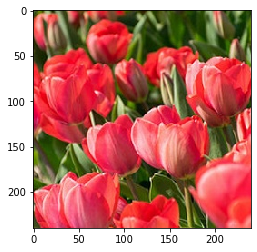

In [18]:
print(x_test_sub.shape)
plt.imshow(cv2.cvtColor(x_test_sub[10], cv2.COLOR_BGR2RGB))
print(type(x_test_sub[6]))
print(x_test_sub[6].shape)

#### 用Learning 出來的 model 對 x_test_sub 做預測

In [19]:
y_test_sub_predict = model.predict(x_test_sub)

In [20]:
print(type(y_test_sub_predict))
print(len(y_test_sub_predict))
print(y_test_sub_predict.shape)
print(y_test_sub_predict[0])
print(y_test_sub_predict[1])
print(y_test_sub_predict[8])

<class 'numpy.ndarray'>
2000
(2000, 5)
[1.3714590e-08 1.0480690e-06 4.8484364e-01 6.0896622e-05 5.1509440e-01]
[3.4467444e-08 3.7179635e-09 2.3616076e-07 8.7804625e-11 9.9999976e-01]
[2.1515870e-08 8.3350699e-10 9.9996877e-01 1.3063166e-07 3.1137824e-05]


#### 對每一個預測的結果，取出機率最大的那個當作預測label

In [21]:
predict_label = np.zeros((len(y_test_sub_predict), ), dtype=int) #預測 label dtype = int32
for i, item in enumerate(y_test_sub_predict):
    predict_label[i] = np.argmax(item)

In [22]:
print(type(predict_label))
print(len(predict_label))
print(predict_label)

<class 'numpy.ndarray'>
2000
[4 4 4 ... 0 4 2]


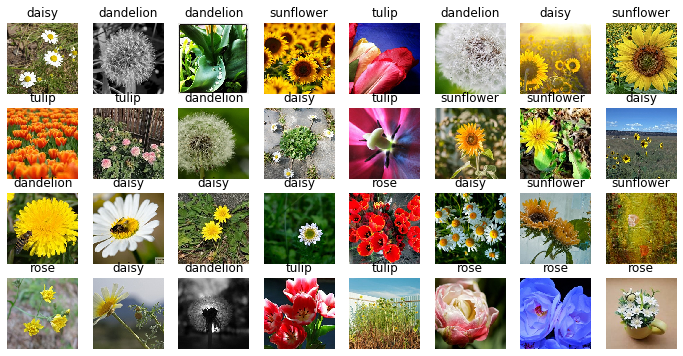

In [24]:
show_num = 32  #秀 show_num 組預測組看看效果

ind_2000 = list(range(len(test_file_name_list)))
random.shuffle(ind_2000)
rand_ind = ind_2000[:show_num] #隨機選取 show_num 個

img_combine(x_test_sub[rand_ind, :], predict_label[rand_ind])

In [ ]:
submission_df = pd.DataFrame()
submission_df['id'] = df['id']
submission_df['flower_class'] = predict_label
print(submission_df)

### 存檔成CSV

In [ ]:
time_array = time.localtime() # localtime
time_str = time.strftime('%m-%dT%H%M%S', time_array)

submission_filename = 'Result_'+predict_model_name[:-3]+'.csv'
submission_df.to_csv(submission_filename, index=False)

* model_12-28T010428.h5              -> Public Score 0.46900
* model_12-28T105443.h5              -> Public Score 0.46800
* model-resnet50-12-28T145129.h5     -> Public Score 0.85200
* model-resnet50-12-28T160610.h5     -> Public Score 0.85200
* model_12-29T020538.h5              -> Public Score 0.62300
* model-resnet50-12-29T122013        -> Public Score 0.85900
* model-resnet50-12-29T124718        -> Public Score 0.92600
* model-resnet50-12-30T093158        -> Public Score 0.89500